In [29]:
#Source functions
import autograd.numpy as np
from autograd import grad, hessian
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from itertools import combinations_with_replacement, chain #used for constructing polynomials

#Functions for ACF and GNR
from source_functions import *

# Data Cleaning

In [30]:
df = load_data("ACF")

# First step of coding: Write functions for the estimation of $\tilde \Phi_t.$

## Estimate $\Phi$

In [31]:
degree= 3
xvars = df[['k', 'l', 'm']].to_numpy()
y = df[['y']].to_numpy()
X_poly = poly_design_matrix(xvars, degree)

Phi = regress(y, X_poly)[1]

#gammas = np.linalg.solve(X_poly.T@X_poly, X_poly.T@y)
#Phi = X_poly @ gammas

#phi_beta_dict = fit_phi_poly_years(df, degree)
df["Phi"] = Phi
#Add into the dataframe
df['Phiprev'] = df.groupby('firm_id')['Phi'].shift(1)
#drop NaNs

## Actual by predicted plot for my polynomial approximation of $\Phi$, run on the entire sample

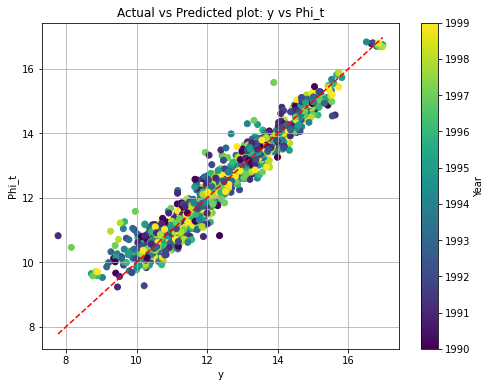

In [32]:
#Actual vs Predicted plot
# Assuming df is a structured NumPy array
actual_values = df['y']     # Extract the actual values
predicted_values = df['Phi'] # Extract the predicted values
years = df['t']

# Create the plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(actual_values, predicted_values, c=years, cmap='viridis', label='Predicted vs Actual')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')

# Add a color bar to represent the year scale
cbar = plt.colorbar(scatter)
cbar.set_label('Year')

# Add labels and title
plt.xlabel('y')
plt.ylabel('Phi_t')
plt.title('Actual vs Predicted plot: y vs Phi_t')
plt.grid(True)

# Show the plot
plt.show()

In [33]:
df_nonans = df.dropna()
#Get all the variables out of the dataframe -- This allows me to use Autograd
y = df_nonans['y'].to_numpy() 
k = df_nonans['k'].to_numpy()  
l = df_nonans['l'].to_numpy()  
Phi = df_nonans['Phi'].to_numpy() 
kprev = df_nonans['kprev'].to_numpy()  
lprev = df_nonans['lprev'].to_numpy() 
Phiprev = df_nonans['Phiprev'].to_numpy() 
#Run GMM
#Initial guess for parameters beta_0, beta_k, beta_l, rho
theta0 = np.array([1,1])
#Weight matrix -- use the identity for now. 
W0 = np.eye(2)
#(2) Get matrix of variables used in exogeneity restrictions
Vex = moment_ex_restrictions_ACF(k, lprev)
#Evaluate the GMM error
obj = gmm_obj_ACF(theta0, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0)

#Create  automatic gradient
autogradient = grad(gmm_obj_ACF)

#
xi = moment_error_ACF(theta0, y, k, l, kprev, lprev, Phi, Phiprev)[0]

autogradient(np.array([0.323, 0.731]), y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0)


array([-0.00056613, -0.00034425])

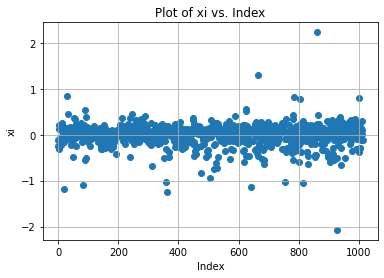

In [34]:
plt.scatter(range(len(xi)), xi, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("xi")
plt.title("Plot of xi vs. Index")
plt.grid(True)
plt.show()

## Now, use a minimization routine to optimize for theta. 
It seems pretty robust, even to crazy initial conditions like $\left[\beta_k, \beta_l\right] = \left[100, 100\right]$

In [35]:
#theta0 = np.array([1, 1])*100 ### Seems pretty robust to crazy initial conditions
theta0 = np.array([1,1])/2   

#Weight matrix -- use the identity for now. 
W0 = np.eye(2)
#(2) Get matrix of variables used in exogeneity restrictions
Vex = moment_ex_restrictions_ACF(k, lprev)

gmm_args = (y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0)

tolerance = 1e-25

theta_results = opt.minimize(gmm_obj_ACF, theta0, args=gmm_args,
                        tol=tolerance, method='Nelder-Mead', options={'maxiter': 10000})

theta_results_grad = opt.minimize(gmm_obj_ACF, theta0, args=gmm_args,
                       tol=tolerance, jac=autogradient, method='L-BFGS-B',                              
                        options={'ftol': 1e-16, 'gtol': 1e-16, 'maxiter': 10000})

#autogradient(theta_results, *gmm_args)

theta=theta_results_grad.x
#Get the slope, rho. It's the slope of the regression used to find the moments. 
rho = moment_error_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev)[1]

print("The gradient at the optimum is: ", autogradient(theta_results_grad.x, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0))
print("The GMM error using Nelder-Mead is:", gmm_obj_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0))
print("The estimates using Nelder-Mead are: [beta_k, beta_l] = ", theta)
print("The GMM error using the gradient is:", gmm_obj_ACF(theta_results_grad.x, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0))
print("The estimates using autograd: [beta_k, beta_l] = ", theta_results_grad.x)
print("The slope of the AR(1) of productivity is: rho = ", rho)
#print("The gradient at [0,0] is: ", autogradient(np.array([0.0,0.0]), y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0))


The gradient at the optimum is:  [1.23390930e-11 7.22985196e-12]
The GMM error using Nelder-Mead is: 1.5796290870339737e-22
The estimates using Nelder-Mead are: [beta_k, beta_l] =  [0.32356761 0.73189068]
The GMM error using the gradient is: 1.5796290870339737e-22
The estimates using autograd: [beta_k, beta_l] =  [0.32356761 0.73189068]
The slope of the AR(1) of productivity is: rho =  0.8821586749401233
